### Inizializzazione e import delle librerie

In [ ]:
!pip3 install SimpleITK
import SimpleITK as sitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Before running the script, reset the runtime to factory reset (Runtime -> Factory Reset Runtime)
# and then change runtime type to GPU (Runtime -> Change runtime type)

# Install libriary dependencies for running deep learning
!pip install tensorflow #==2.9.0          #2.1.0
!pip install keras #==2.3.1

!pip install classification-models-3D
!pip install segmentation-models-3D
!pip install volumentations-3D

!pip install h5py #==2.10.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

import os
import random
import copy
from tabulate import tabulate
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from tqdm import tqdm
import skimage
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage import measure
import skimage.metrics as ski_metrics
from skimage.util import *
from scipy import ndimage
from scipy.ndimage import zoom
import json
import time
import math
import volumentations
from volumentations import *

# Import delle librerie aggiuntive per la lettura e visualizzazione
current_dir = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge'
os.chdir(current_dir)
from utils import load_case
from visualize import visualize
import plotly.express as px

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

import segmentation_models_3D as sm
from segmentation_models_3D import Unet

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

## Caricamento dizionari

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/train_info_128'
fp= open(file_path)
volumes_train_info = json.loads(fp.read())

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Kidney Cancer Challenge/val_info_128'
fp= open(file_path)
volumes_val_info = json.loads(fp.read())

## Funzioni

In [ ]:
def create_path(gen_path, folder_name):
  # Funzione che riceve in input il nome di una cartella da creare e restituisce il percorso 
  # appena generato; se la cartella indicata è già presente all'interno del drive viene 
  # restituito il percorso (già esistente) relativo a questa
  # args:   - gen_path: percorso 'genitore' all'interno del quale viene creata la cartella folder_name
  #         - folder_name: nome della cartella da creare (o da indirizzare, se già presente nel drive)
  # output: - path: percorso relativo alla cartella folder_name
  path = os.path.join(gen_path, folder_name)
  if not os.path.exists(path):
      os.mkdir(path)
  return path

In [ ]:
def sitk_image_to_data(image):
    data = sitk.GetArrayFromImage(image)
    if len(data.shape) == 3:
      data = np.rot90(data, 1, axes=(0, 2))     # rotazione con cui è stata allenata la rete
    return data

def data_to_sitk_image(data, spacing=(1., 1., 1.),is_2D = False):
    if len(data.shape) == 3:
      data = np.rot90(data, -1, axes=(0, 2))     # rotazione con cui è stata allenata la rete
    image = sitk.GetImageFromArray(data)
    image.SetSpacing(np.asarray(spacing, dtype= float))
    return image

In [ ]:
def resample_image(image, out_spacing=(1.0, 1.0, 1.0), out_size=None, is_label=False, pad_value=0, is_prediction= False):
    """Resamples an image to given element spacing and output size."""

    original_spacing = np.array(image.GetSpacing())
    original_size = np.array(image.GetSize())

    if len(out_spacing)==2:
      out_spacing = (original_spacing[0], out_spacing[0], out_spacing[1])

    if out_size is None:
        out_size = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
    else:
      if len(out_size)==2:
        out_size = np.array(out_size)
        out_size_temp = np.round(np.array(original_size * original_spacing / np.array(out_spacing))).astype(int)
        out_size = np.insert(out_size,0,out_size_temp[0])
      elif len(out_size)==3:
        out_size = np.array(out_size)
    
    original_direction = np.array(image.GetDirection()).reshape(len(original_spacing),-1)
    original_center = (np.array(original_size, dtype=float) - 1.0) / 2.0 * original_spacing
    out_center = (np.array(out_size, dtype=float) - 1.0) / 2.0 * np.array(out_spacing)

    original_center = np.matmul(original_direction, original_center)
    out_center = np.matmul(original_direction, out_center)
    out_origin = np.array(image.GetOrigin()) + (original_center - out_center)

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size.tolist())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(out_origin.tolist())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(pad_value)

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkLinear)

    if is_prediction:
        return resample.Execute(sitk.Cast(image, sitk.sitkFloat32))
    else:
        return resample.Execute(sitk.Cast(image, sitk.sitkUInt8))   

### Ricostruzione volume

In [ ]:
def cut_selection(mask_auto, n, volumes_info): 
  # - la funzione label del modulo measure esegue la connected component analysis;
  #   dandole in input un volume ci restituisce una maschera delle stesse dimensioni 
  #   di questo, al cui interno viene associata una label diversa ad ogni regione individuata  
  #   NB: con connectivity=3 diciamo di essere interessati all'individuazione di 
  #       componenti connessi nelle 3 dimensioni (quindi volumi)
  # - la funzione regionprops restituisce le proprietà di ciascuna delle regioni individuate
  aree = []             # vettore delle aree delle regioni - ci sarà utile per individuare le due aree maggiori
  labels = []           # vettore che conterrà le label che sono state associate a ciascuna regione individuata
  centroids = []        # vettore dei centroidi delle regioni; questa informazione ci servirà alla fine di tutto, quando dovremo ricostruire le dimensioni iniziali avremo bisogno di sapere dove 'ancorare' le maschere automatiche fornite in output dalla 3D
  bboxes = []
  mask_labels = measure.label(mask_auto, connectivity = 3)
  regions = measure.regionprops(label_image=mask_labels)
  for region in regions:
    aree.append(region.area)
    labels.append(region.label)
    centroids.append(region.centroid)
    bboxes.append(region.bbox)

  # Hp: le regioni di interesse sono quelle con estensione maggiore
  area1 = max(aree)
  ind1 = aree.index(area1)
  label1 = labels[ind1]
  centroid1 = np.round(np.array(centroids[ind1]))

  bbox1 = bboxes[ind1]
  volumes_info['{}'.format(n)]['centroid_1_out'] = list(centroid1)     # qui prima c'era "Centroide 1 manuale"
  aree.pop(ind1)
  labels.pop(ind1)
  centroids.pop(ind1)
  
  if (len(aree)!=0) and (max(aree)>area1/25):    # condizione per considerare solo aree 'significative'  
    area2 = max(aree)
    ind2 = aree.index(area2)
    label2 = labels[ind2]
    centroid2 = np.round(np.array(centroids[ind2]))
    if centroid2[2] in range(bbox1[2],bbox1[5]):
      # Non considerare più questa regione
      aree.pop(ind2)
      labels.pop(ind2)
      centroids.pop(ind2)
      # cerca la successiva 
      area2 = max(aree)
      ind2 = aree.index(area2)
      label2 = labels[ind2]
      centroid2 = np.round(np.array(centroids[ind2]))

    volumes_info['{}'.format(n)]['centroid_2_out'] = list(centroid2)        # qui prima c'era "Centroide 2 manuale"
    # selezione della coordinata (x) di 'taglio'
    for region in regions:
      if region.label == label1:
        x1_min = region.bbox[2]
        x1_max = region.bbox[5]
        # print('bbox1: ', region.bbox)
      elif region.label == label2:
        x2_min = region.bbox[2]
        x2_max = region.bbox[5]
        # print('bbox2: ', region.bbox)
    if x1_max > x2_max:    
      # la regione 1 si trova a destra
      if x1_min < x2_max:  # se le due regioni sono parzialmente sovrapposte...
        #...scegliamo come punto di taglio il punto medio della sovrapposizione
        cut = x2_max + ((x2_max-x1_min)/2)    
      else:
        #...altrimenti il punto medio dello spazio "vuoto" tra le due regioni
        cut = x2_max + (x1_min-x2_max)/2      
    else:             
      # la regione 2 si trova a destra
      if x2_min < x1_max:
        cut = x1_max + ((x1_max-x2_min)/2)
      else:
        cut = x1_max + (x2_min-x1_max)/2
  else:
    # se è presente un solo grande componente connesso (e.g. caso 5), allora non viene effettuato alcun taglio 
    cut = 0      

  volumes_info['{}'.format(n)]['cut'] = int(cut)
  return int(cut), volumes_info

def volume_separation(volume, cut):
  volume1 = volume[:,:,:cut]
  volume2 = volume[:,:,cut:]
  return volume1, volume2

In [ ]:
def get_centroid(subvolume):
  aree = []             # vettore delle aree delle regioni - ci sarà utile per individuare le due aree maggiori
  centroids = []        # vettore dei centroidi delle regioni
  
  mask_labels = measure.label(subvolume, connectivity = 3)
  regions = measure.regionprops(label_image=mask_labels)
  for region in regions:
    aree.append(region.area)
    centroids.append(region.centroid)
  area1 = max(aree)
  ind1 = aree.index(area1)
  centroid = np.round(np.array(centroids[ind1])).astype(int)
  return centroid

In [ ]:
def get_bbox(segmentation):
    aree = []
    mask_labels = measure.label(segmentation, connectivity = 3)
    regions = measure.regionprops(label_image=mask_labels)
    for region in regions:
      aree.append(region.area)
    ind1 = aree.index(max(aree))
    region = regions[ind1]
    return region.bbox

In [ ]:
def alignment(SEG, MASK, centroid):
  # descrizione: Questa funzione serve a posizionare il risultato della rete 3D all'interno 
  #              di un volume di segmentazione che servirà a ricostruire il volume di partenza 
  # args:        - SEG: 3d array inizializzato a zero al cui interno verrà posizionata MASK; []
  #              - MASK: maschera automatica output della 3D, viene posizionata all'interno di SEG facendo coincidere 
  #                      il suo centroide con il centroide originale del volume a cui si riferisce
  #              - centroid: centroide nel SR di SEG, quindi riferito al volume ricostruito nel postprocess della 2D
  # funzioni:    get_centroid(), get_bbox()

  # coordinate del centroide di riferimento (SR di SEG)
  z_cs, y_cs, x_cs = centroid
  # print("centroide salvato: {}".format(centroid))
  z_cs = int(np.ceil(z_cs))
  y_cs = int(np.ceil(y_cs))
  x_cs = int(np.ceil(x_cs))
  # estrazione del centroide dalla maschera (SR di MASK)
  MASK_bin = copy.deepcopy(MASK)
  MASK_bin[MASK_bin>1]=1

  if sum(sum(sum(MASK_bin))) != 0:
    C = get_centroid(MASK_bin)
    z_cm, y_cm, x_cm = C
    z_cm = int(np.ceil(z_cm))
    y_cm = int(np.ceil(y_cm))
    x_cm = int(np.ceil(x_cm))
    # estrazione delle coordinate della bounding box che racchiudono solo il volume individuato
    bbox = get_bbox(MASK_bin)
    z_min, y_min, x_min, z_max, y_max, x_max = bbox
    # calcolo degli spostamenti della bounding box rispetto al centroide della maschera automatica (C)
    dx_2 = x_max - x_cm
    dx_1 = x_cm - x_min
    dy_2 = y_max - y_cm
    dy_1 = y_cm - y_min
    dz_2 = z_max - z_cm
    dz_1 = z_cm - z_min
    
    # Per risolvere il problema velocemente porto i negativi a 0
    Z1 = z_cs-dz_1
    Z2 = z_cs+dz_2
    Y1 = y_cs-dy_1
    Y2 = y_cs+dy_2
    X1 = x_cs-dx_1
    X2 = x_cs+dx_2

    if Z1 < 0:
      z_min = z_min + abs(Z1)
      Z1 = np.clip(z_cs-dz_1, 0, 1000)
    elif Y1 < 0:
      y_min = y_min + abs(Y1)
      Y1 = np.clip(y_cs-dy_1, 0, 1000)
    elif X1 <0:
      x_min = x_min + abs(X1)
      X1 = np.clip(x_cs-dx_1, 0, 1000)
    if Z2>SEG.shape[0]:
      z_max = z_max - (Z2-SEG.shape[0])
    if Y2>SEG.shape[1]:
      y_max = y_max - (Y2-SEG.shape[1])
    if X2>SEG.shape[2]:
      x_max = x_max - (X2-SEG.shape[2])

    SEG[Z1:Z2, Y1:Y2, X1:X2] = MASK[z_min:z_max, y_min:y_max, x_min:x_max]

  return SEG

## Indirizzamento cartelle ROI

In [ ]:
#Creazione delle cartelle che conterranno le ROI estratte
path_ROI = create_path(current_dir, 'ROI')                              # CAMBAIRE NOME DATASET A SECONDA DELLA PROVA
path_ROI_train_vol = create_path(path_ROI,'train_volumes')
path_ROI_train_mask_auto = create_path(path_ROI, 'train_masks_auto')
path_ROI_train_mask = create_path(path_ROI, 'train_masks_manual')
path_ROI_val_vol = create_path(path_ROI, 'val_volumes')
path_ROI_val_mask_auto = create_path(path_ROI, 'val_masks_auto')
path_ROI_val_mask = create_path(path_ROI, 'val_masks_manual')
path_ROI_test_vol = create_path(path_ROI, 'test_volumes')
path_ROI_test_mask_auto = create_path(path_ROI, 'test_masks_auto')
path_ROI_test_mask = create_path(path_ROI, 'test_masks_manual')

In [ ]:
IMG_WIDTH, IMG_HEIGHT = [328,328]                  # dimensioni dell'output della 2D
ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH = [128,128,128]    # dimensioni dell'input della 3D
IMG_CHANNELS = 1
N_CLASSES = 3

# Estrazione della lista di volumi del training e validation set
train_vol = sorted(os.listdir(path_ROI_train_vol))
val_vol = sorted(os.listdir(path_ROI_val_vol))
# Estrazione della lista di maschere del training e validation set
train_mask = sorted(os.listdir(path_ROI_train_mask))
val_mask = sorted(os.listdir(path_ROI_val_mask))

n_volumes_train = len(train_vol)
n_volumes_val = len(val_vol)

### Verifica visualizzazione ROI per il Training Set

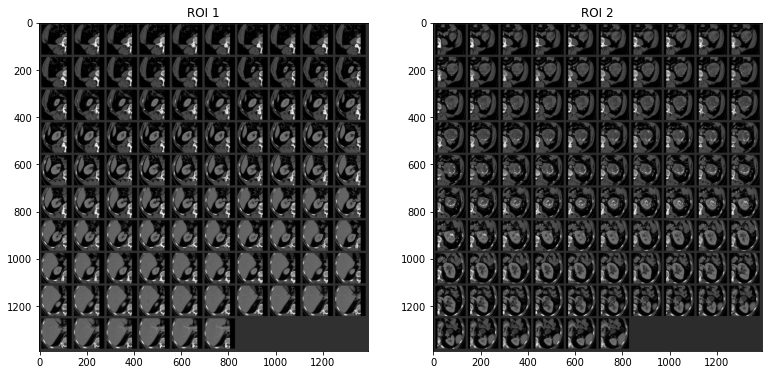

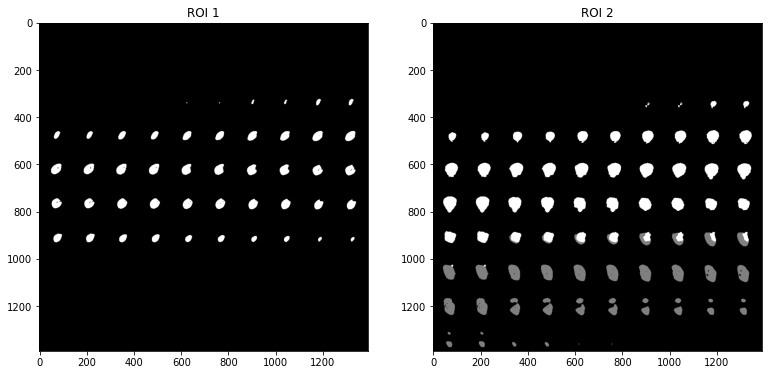

In [ ]:
n = 73
case_name = "case_" + str(n).zfill(5)
ROI1_img = np.load(path_ROI_train_vol+'/'+case_name+'_ROI_1.npy')
m1 = montage(ROI1_img, grid_shape=(10,10),padding_width=10, multichannel=False)
ROI2_img = np.load(path_ROI_train_vol+'/'+case_name+'_ROI_2.npy')
m2 = montage(ROI2_img, grid_shape=(10,10),padding_width=10, multichannel=False)
display2( m1, m2, 'ROI 1', 'ROI 2', color_bar= False)
ROI1 = np.load(path_ROI_train_mask+'/'+case_name+'_ROI_1.npy')
m1 = montage(ROI1, grid_shape=(10,10),padding_width=10, multichannel=False)
ROI2 = np.load(path_ROI_train_mask+'/'+case_name+'_ROI_2.npy')
m2 = montage(ROI2, grid_shape=(10,10),padding_width=10, multichannel=False)
display2( m1, m2, 'ROI 1', 'ROI 2', color_bar= False)

### Verifica visualizzazione ROI per il Validation Set

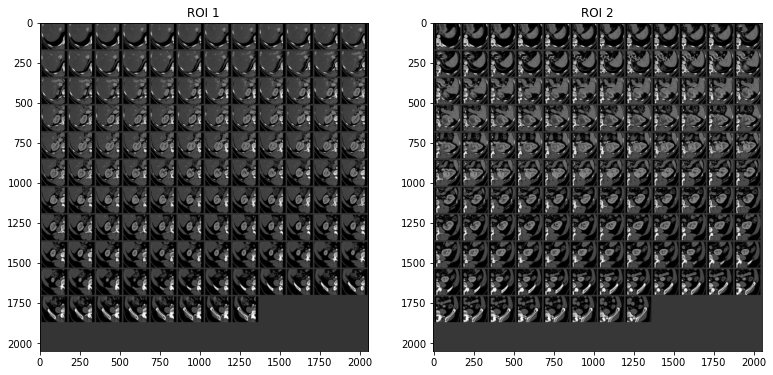

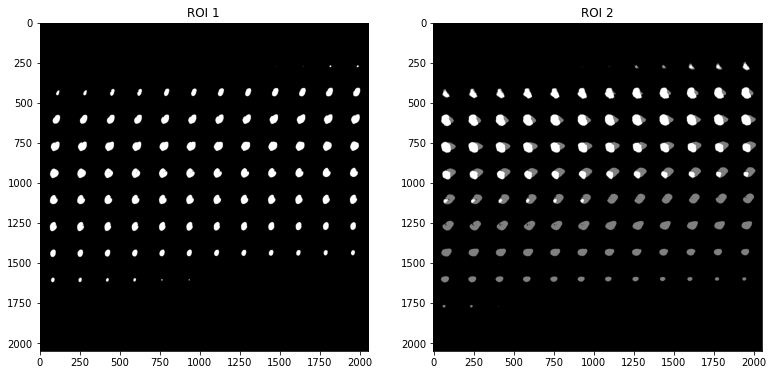

In [ ]:
n = 149
case_name = "case_" + str(n).zfill(5)
ROI1_img = np.load(path_ROI_val_vol+'/'+case_name+'_imaging_1.npy')
m1 = montage(ROI1_img, grid_shape=(12,12),padding_width=10, multichannel=False)
ROI2_img = np.load(path_ROI_val_vol+'/'+case_name+'_imaging_2.npy')
m2 = montage(ROI2_img, grid_shape=(12,12),padding_width=10, multichannel=False)
display2( m1, m2, 'ROI 1', 'ROI 2', color_bar= False)

ROI1 = np.load(path_ROI_val_mask+'/'+case_name+'_segmentation_1.npy')
m1 = montage(ROI1, grid_shape=(12,12),padding_width=10, multichannel=False)
ROI2 = np.load(path_ROI_val_mask+'/'+case_name+'_segmentation_2.npy')
m2 = montage(ROI2, grid_shape=(12,12),padding_width=10, multichannel=False)
display2( m1, m2, 'ROI 1', 'ROI 2', color_bar= False)
# imsave(current_dir+'skimage_montage_default.jpg', m)

## Preparazione delle matrici

In [ ]:
# Inizializzazioni matrici
X_train = np.zeros((n_volumes_train,ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((n_volumes_train,ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,N_CLASSES), dtype=np.float32)

i = 0          
for n, id_ in tqdm(enumerate(train_vol), total=len(train_vol)):           
  # n: 0-num_immagini; id_:nome della n-esima immagine   
  case_name = str(id_) 
  # Lettura volume 
  Vol = np.load(path_ROI_train_vol+'/'+case_name) 
  Vol = np.expand_dims(Vol, 3)
  X_train[i] = Vol
  i += 1
     
j = 0          # contatore che ci serve per riempire la matrice con tutte le slice di tutte le maschere
for n, id_ in tqdm(enumerate(train_mask), total=len(train_mask)):
  # n: 0-num_immagini; id_:nome della n-esima immagine    
  case_name = str(id_) 
  # Lettura maschera BW 
  Mask = np.load(path_ROI_train_mask+'/'+case_name)
  # Conversione della maschera in dato categorico 
  mask = to_categorical(Mask, num_classes=N_CLASSES, dtype='float32') 
  Y_train[j] = mask 
  j += 1

100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


In [ ]:
# Inizializzazioni matrici
X_val = np.zeros((n_volumes_val,ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,IMG_CHANNELS), dtype=np.uint8)
Y_val = np.zeros((n_volumes_val,ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,N_CLASSES), dtype=np.float32)

i = 0          
for n, id_ in tqdm(enumerate(val_vol), total=len(val_vol)):               
  # n: 0-num_immagini; id_:nome della n-esima immagine   
  case_name = str(id_) 
  # Lettura volume 
  Vol = np.load(path_ROI_val_vol+'/'+case_name) 
  Vol = np.expand_dims(Vol, 3)
  X_val[i] = Vol
  i += 1
     
j = 0          # contatore che ci serve per riempire la matrice con tutte le slice di tutte le maschere
for n, id_ in tqdm(enumerate(val_mask), total=len(val_mask)):
  # n: 0-num_immagini; id_:nome della n-esima immagine 
  case_name = str(id_) 
  # Lettura maschera BW 
  Mask = np.load(path_ROI_val_mask+'/'+case_name)
  # Conversione della maschera in dato categorico 
  mask = to_categorical(Mask, num_classes=N_CLASSES, dtype='float32') 
  Y_val[j] = mask 
  j += 1

## Rete 3D

### Prima rete - Inizializzazione pesi

In [ ]:
# Ottimizzatore
initial_learning_rate = 0.0001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
optimizer = Adam(learning_rate=initial_learning_rate)
# Funzione di loss
total_loss = sm.losses.jaccard_loss 
# Metrica
metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [ ]:
BACKBONE = 'resnet50'
activation = 'softmax'

model = sm.Unet(BACKBONE, 
                classes=N_CLASSES, 
                input_shape=(ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH, IMG_CHANNELS), 
                encoder_weights= None,       
                encoder_freeze = False,
                decoder_block_type='transpose',
                activation = activation)

model.compile(optimizer = optimizer, loss=total_loss, metrics=metrics)

In [ ]:
# Callbacks definition
csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor='val_loss',  
                               min_delta=0,
                               patience=7,
                               verbose=1, 
                               mode='auto')   

filepath = "model_3D.h5"               

callbacks_list = [csv_logger, earlystopping]  

In [ ]:
# Parametri della rete
batch_size = 2
n_epochs = 100

train_ROI_vol_list = sorted(os.listdir(path_ROI_train_vol))
train_ROI_mask_list = sorted(os.listdir(path_ROI_train_mask))

val_ROI_vol_list = sorted(os.listdir(path_ROI_val_vol))
val_ROI_mask_list = sorted(os.listdir(path_ROI_val_mask))

n_img_train = len(train_ROI_vol_list) # numero delle immagini di train
n_img_val = len(val_ROI_vol_list) # numero delle immagini di validation

steps_per_epoch = np.ceil(float(n_img_train)/float(batch_size))
val_steps_per_epoch = np.ceil(float(n_img_val)/float(batch_size))

history=model.fit(x=X_train,
                  y=Y_train,
                  batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_data=(X_val,Y_val),
          validation_steps=val_steps_per_epoch,
          shuffle = True,
          epochs= n_epochs,
          callbacks = callbacks_list)

Epoch 1/100
100/100 [==============================] - 141s 1s/step - loss: 0.7472 - iou_score: 0.3122 - val_loss: 0.9697 - val_iou_score: 0.0312
Epoch 2/100
100/100 [==============================] - 109s 1s/step - loss: 0.4885 - iou_score: 0.5673 - val_loss: 0.6186 - val_iou_score: 0.4532
Epoch 3/100
100/100 [==============================] - 109s 1s/step - loss: 0.4163 - iou_score: 0.5945 - val_loss: 0.4299 - val_iou_score: 0.5974
Epoch 4/100
100/100 [==============================] - 109s 1s/step - loss: 0.3755 - iou_score: 0.6430 - val_loss: 0.4119 - val_iou_score: 0.5994
Epoch 5/100
100/100 [==============================] - 109s 1s/step - loss: 0.3495 - iou_score: 0.6621 - val_loss: 0.3699 - val_iou_score: 0.6379
Epoch 6/100
100/100 [==============================] - 109s 1s/step - loss: 0.3240 - iou_score: 0.6866 - val_loss: 0.4282 - val_iou_score: 0.5753
Epoch 7/100
100/100 [==============================] - 109s 1s/step - loss: 0.3271 - iou_score: 0.6869 - val_loss: 0.3588 - 

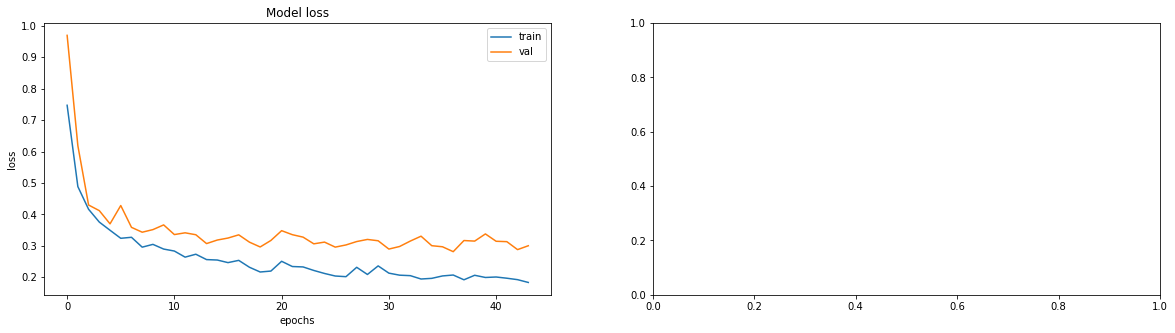

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
#for i, metric in enumerate(['binary_accuracy','loss','recall_2','precision_2']):
for i, metric in enumerate(['loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

#### Salvataggio pesi

In [ ]:
# Save the weights
model.save_weights('weights_2_128')

#### Prova predizione

In [ ]:
model = load_model(current_dir+'/model_3D.h5', compile= False)

In [ ]:
def predict3D(volume):
    softmax = model.predict(np.expand_dims(volume, axis=0))
    softmax = np.reshape(softmax,(ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,N_CLASSES))

    prediction = np.argmax(softmax,axis=-1)
    prediction = prediction.astype(np.uint8)
    return prediction 

### Seconda rete

In [ ]:
# Ottimizzatore
metrics = [sm.metrics.IOUScore(threshold=0.5)]
initial_learning_rate = 0.00001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)
optimizer = Adam(learning_rate=initial_learning_rate)

# Funzione di loss
smooth = 1
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)
    
# Metrica
metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [ ]:
BACKBONE = 'resnet50'
activation = 'softmax'

model2 = sm.Unet(BACKBONE, 
                classes=N_CLASSES, 
                input_shape=(ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH, IMG_CHANNELS), 
                encoder_weights= None,    
                encoder_freeze = True,       
                decoder_block_type='transpose',
                activation = activation)

model2.compile(optimizer = optimizer, loss=tversky_loss, metrics=metrics)
model2.load_weights('weights_2_128')

In [ ]:
filepath = "3D_Unet.h5"

# Callbacks definition
csv_logger = CSVLogger('./log.out', append=True, separator=';')

earlystopping = EarlyStopping(monitor='val_loss',   # controllare cosa monitorare con early stopping
                               min_delta=0,
                               patience=10,
                               verbose=1, 
                               mode='auto')   #dovrebbe andar bene per evitare overfitting

modelcheckpoint = ModelCheckpoint(filepath,
                                  monitor="val_loss",
                                  verbose = 1, 
                                  save_best_only=True) 

callbacks_list = [csv_logger, modelcheckpoint, earlystopping]  

In [ ]:
# Parametri della rete

batch_size = 1
n_epochs = 100

train_ROI_vol_list = sorted(os.listdir(path_ROI_train_vol))
train_ROI_mask_list = sorted(os.listdir(path_ROI_train_mask))

val_ROI_vol_list = sorted(os.listdir(path_ROI_val_vol))
val_ROI_mask_list = sorted(os.listdir(path_ROI_val_mask))
n_img_train = len(train_ROI_vol_list) # numero delle immagini di train
n_img_val = len(val_ROI_vol_list) # numero delle immagini di validation

steps_per_epoch = np.ceil(float(n_img_train)/float(batch_size))
val_steps_per_epoch = np.ceil(float(n_img_val)/float(batch_size))

history=model2.fit(x=X_train,
                  y=Y_train,
                  batch_size=batch_size,
          steps_per_epoch=steps_per_epoch,
          validation_data=(X_val,Y_val),
          validation_steps=val_steps_per_epoch,
          shuffle = True,
          epochs= n_epochs,
          callbacks = callbacks_list)

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.2306 - iou_score: 0.8969
Epoch 1: val_loss improved from inf to 0.31097, saving model to model_3D_cce_dice_batch1.h5
200/200 [==============================] - 146s 629ms/step - loss: 0.2306 - iou_score: 0.8969 - val_loss: 0.3110 - val_iou_score: 0.7822
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.2282 - iou_score: 0.8913
Epoch 2: val_loss did not improve from 0.31097
200/200 [==============================] - 116s 582ms/step - loss: 0.2282 - iou_score: 0.8913 - val_loss: 0.3256 - val_iou_score: 0.7946
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.2245 - iou_score: 0.8885
Epoch 3: val_loss did not improve from 0.31097
200/200 [==============================] - 116s 581ms/step - loss: 0.2245 - iou_score: 0.8885 - val_loss: 0.3219 - val_iou_score: 0.7983
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2221 - iou_score: 0.9031
Epoch 4: va

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = ax.ravel()
#for i, metric in enumerate(['binary_accuracy','loss','recall_2','precision_2']):
for i, metric in enumerate(['loss']):
    ax[i].plot(model2.history.history[metric])
    ax[i].plot(model2.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

#### Prova predizione

In [ ]:
model2 = load_model(current_dir+'/3D_Unet.h5', compile= False)

In [ ]:
def predict3D(volume):
    softmax = model2.predict(np.expand_dims(volume, axis=0))
    softmax = np.reshape(softmax,(ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH,N_CLASSES))

    prediction = np.argmax(softmax,axis=-1)
    prediction = prediction.astype(np.uint8)
    return prediction 

In [ ]:
folder = 'Data'
path_val_mask = "/".join((current_dir,folder,'val_masks'))
n = 122
id_ = 'case_' + str(n).zfill(5)

mask_manual = np.load(path_val_mask+'/'+id_+'_segmentation.npy')
ROI1_vol = np.load("/".join((path_ROI_val_vol,str(id_)+'_ROI_1.npy')))
ROI2_vol = np.load("/".join((path_ROI_val_vol,str(id_)+'_ROI_2.npy')))
ROI1_mask = np.load("/".join((path_ROI_val_mask,str(id_)+'_ROI_1.npy')))
ROI2_mask = np.load("/".join((path_ROI_val_mask,str(id_)+'_ROI_2.npy')))
prediction1 = predict3D(ROI1_vol)
prediction2 = predict3D(ROI2_vol)

case_00122


### Metriche

* Dice score

In [ ]:
def compute_dice_coefficient(mask_gt, mask_pred):
  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  return 2*volume_intersect / volume_sum 

In [ ]:
def DSC(segmentation,prediction):
  prediction_kidney_tumor = np.array(prediction>=1)
  prediction_tumor = np.array(prediction==2)
  segmentation_kidney_tumor = np.array(segmentation>=1)
  segmentation_tumor = np.array(segmentation==2)
  dice_kidney_tumor = compute_dice_coefficient(segmentation_kidney_tumor, prediction_kidney_tumor)
  dice_tumor = compute_dice_coefficient(segmentation_tumor, prediction_tumor)
  return dice_kidney_tumor, dice_tumor

* RVD

In [ ]:
def RVD_3D(mask_auto, manual):  
    tu_p = mask_auto<2
    tk_p= mask_auto>1

    tu_m = manual<2
    tk_m= manual>1

    vol1 = np.count_nonzero(tk_p)
    vol2 = np.count_nonzero(tk_m)  
    if 0 == vol2:
      raise RuntimeError('La maschera manuale non contiene alcun complesso rene-tumore') 
    tk_rvd = (vol1 - vol2) / float(vol2)

    vol1 = np.count_nonzero(tu_p)
    vol2 = np.count_nonzero(tu_m)
    if 0 == vol2:
      raise RuntimeError('La maschera manuale non contiene alcun tumore') 
    tu_rvd = (vol1 - vol2) / float(vol2)

    return tk_rvd, tu_rvd

* Calcolo metriche per il Training

In [ ]:
def calcolo_metriche(mask_auto, mask_manual,original_spacing):
    
    HD_slice = []
    for sl in range(0,len(mask_auto)):
      mask_auto_sl = copy.deepcopy(mask_auto[sl])
      manual = copy.deepcopy(mask_manual[sl])
      # HD va' calcolata sui tumori
      mask_auto_sl[mask_auto_sl<2] = 0
      manual[manual<2] = 0
      index_a = measure.find_contours(mask_auto_sl,level=1)        
      index_m = measure.find_contours(manual,level=1)  
      # La distanza di Hausdorff può essere calcolata nelle slice in cui c'è solo una curva nella mask auto e solo una curva nella mask manual
      if len(index_a) == 1 and len(index_m) == 1:
        contour_a = mask_auto_sl[index_a[0].astype(int)] 
        contour_m = manual[index_m[0].astype(int)] 
        temp_HD = ski_metrics.hausdorff_distance(contour_a, contour_m)
        # calcolo l'HD per ciascuna slice appartenente ad un volume
        HD_slice.append(temp_HD*original_spacing)    # conversione in mm

    DSC_TK,DSC_TU = DSC(mask_manual, mask_auto)
    RVD_TK,RVD_TU = RVD(mask_auto, mask_manual)
    if HD_slice:
      HD_totale = np.sum(np.array(HD_slice))/len(HD_slice)
    else:
      HD_totale = []

    return DSC_TK, DSC_TU, RVD_TK, RVD_TU, HD_totale

* Intera pipeline di calcolo delle metriche

In [ ]:
def postprocess_3D(MASK_AUTO_1, MASK_AUTO_2, n, volumes_info):
  n_key = "{}".format(n)                                    # conversione per rendere compatibile l'indice numerico con la key del dizionario
  obtained_size_3D = volumes_info[n_key]["obtained_size_3D"]
  original_spacing = volumes_info[n_key]["original_spacing"]
  original_size = volumes_info[n_key]["original_size"]
  spacing_3D = [1.5,1.5,1.5]
  SEG_AUTO = np.zeros((obtained_size_3D),dtype=np.float32)                   # inizializzazione di una matrice di zeri che conterrà le due ROI output della rete 3D  

  # recupero l'informazione sulla posizione dei centroidi delle due regioni (rene e rene+tumore)
  centroid_1 = volumes_info[n_key]["centroid_1_out"]   
  centroid_2 = volumes_info[n_key]["centroid_2_out"]
  x_c1 = centroid_1[2]
  x_c2 = centroid_2[2]
  if x_c2 < x_c1:
    centroid_2 = copy.deepcopy(volumes_info["{}".format(n)]["centroid_1_out"])
    centroid_1 = copy.deepcopy(volumes_info["{}".format(n)]["centroid_2_out"])

  if n == 5:
    SEG_AUTO = alignment(SEG_AUTO, MASK_AUTO_1, centroid_1)
  else:
    # ciascuna ROI viene posizionata all'interno del 3d ndarray inizializzato a 0, prestando attenzione a far coincidere i centroidi
      SEG_AUTO = alignment(SEG_AUTO, MASK_AUTO_1, centroid_1) 
      SEG_AUTO = alignment(SEG_AUTO, MASK_AUTO_2, centroid_2)  

  # converto maschera e volume a immagine ITK per ricampionare la risoluzione
  SEG_AUTO = data_to_sitk_image(SEG_AUTO, spacing = spacing_3D)

  # Ricampiono alla risoluzione originale
  SEG_AUTO = resample_image(SEG_AUTO, out_spacing=original_spacing, out_size = original_size, is_label=True, pad_value=0, is_prediction= True)
  SEG_AUTO = sitk_image_to_data(SEG_AUTO)

  return SEG_AUTO.astype(np.uint8)

#### Prova ricostruzione

In [ ]:
ROI_DEPTH, ROI_HEIGHT, ROI_WIDTH = [128,128,128]
N_CLASSES = 3

In [ ]:
n = 88
id_ = "case_" + str(n).zfill(5)
# segmentation = np.load(path_train_mask+'/'+id_+'_segmentation.npy')
segmentation = sitk.ReadImage("/".join((current_dir,'training',id_,'segmentation.nii.gz')))
segmentation = sitk_image_to_data(segmentation)
VOL_1 = np.load(path_ROI_train_vol+'/'+id_+'_ROI_1.npy')
VOL_2 = np.load(path_ROI_train_vol+'/'+id_+'_ROI_2.npy')
original_spacing = volumes_train_info["{}".format(n)]['original_spacing']
# PREDICT 3D
MASK_AUTO_1 = predict3D(VOL_1)
MASK_AUTO_2 = predict3D(VOL_2)

# RICOSTRUZIONE VOLUME
prediction = postprocess_3D(MASK_AUTO_1, MASK_AUTO_2, n, volumes_train_info)

## Predizione

In [ ]:
def volume_prediction(list_vol,path_prediction,volumes_info, is_val = False, is_test = False):
    DSC_TK_vol = []
    DSC_TU_vol = []
    RVD_TK_vol = []
    RVD_TU_vol = []
    HD_vol = []

    for n, id_ in tqdm(enumerate(list_vol), total=len(list_vol)):
        if is_val:
          folder = 'validation'
          n = n+100
        elif is_test:
          folder = 'test'
          n = n+150
        else:
          folder = 'training'

        id_ = "case_" + str(n).zfill(5)
        VOL_1 = np.load(path_prediction+'/'+id_+'_ROI_1.npy')
        VOL_2 = np.load(path_prediction+'/'+id_+'_ROI_2.npy')
        original_spacing = volumes_info["{}".format(n)]['original_spacing']
        # PREDICT 3D
        MASK_AUTO_1 = predict3D(VOL_1)
        MASK_AUTO_2 = predict3D(VOL_2)

        # RICOSTRUZIONE VOLUME
        prediction = postprocess_3D(MASK_AUTO_1, MASK_AUTO_2, n, volumes_info)

        segmentation = sitk.ReadImage("/".join((current_dir,folder,id_,'segmentation.nii.gz')))
        segmentation = sitk_image_to_data(segmentation)
        # display2(segmentation[len(segmentation)//2],prediction[len(prediction)//2], 'segmentation', 'prediction', color_bar=False)

        DSC_TK, DSC_TU, RVD_TK, RVD_TU, HD = calcolo_metriche(prediction, segmentation, original_spacing)
        # DSC_TK, DSC_TU, RVD_TK, RVD_TU = calcolo_metriche(prediction, segmentation, original_spacing)
        # print(" caso {}: {} - {}".format(n,round(DSC_TK,2),round(DSC_TU,2)))
        print(" caso {}: {}".format(n,round(HD,2)))
        DSC_TK_vol.append(DSC_TK) 
        DSC_TU_vol.append(DSC_TU)
        RVD_TK_vol.append(RVD_TK) 
        RVD_TU_vol.append(RVD_TU)
        if HD:
          HD_vol.append(HD)
    return DSC_TK_vol, DSC_TU_vol, RVD_TK_vol, RVD_TU_vol, HD_vol
    # return DSC_TK_vol, DSC_TU_vol, RVD_TK_vol, RVD_TU_vol

### Training Set

In [ ]:
DSC_TK_train_vol = []
DSC_TU_train_vol = []
RVD_TK_train_vol = []
RVD_TU_train_vol = []
HD_train_vol = []

train_vol = sorted(os.listdir(current_dir+'/training'))
DSC_TK_train_vol, DSC_TU_train_vol, RVD_TK_train_vol, RVD_TU_train_vol, HD_train_vol = volume_prediction(train_vol,path_ROI_train_vol,volumes_train_info)

In [ ]:
print("DSC rene+tumore: ",round(sum(DSC_TK_train_vol)/len(DSC_TK_train_vol)*100,2))
print("DSC tumore: ",round(sum(DSC_TU_train_vol)/len(DSC_TU_train_vol)*100,2))
print("RVD rene+tumore: ",round(sum(RVD_TK_train_vol)/len(RVD_TK_train_vol),5))
print("RVD tumore:",round(sum(RVD_TU_train_vol)/len(RVD_TU_train_vol),5))

DSC rene+tumore:  89.87
DSC tumore:  63.8
RVD rene+tumore:  0.19412
RVD tumore: -0.00037


In [ ]:
# Tumour + Kidney
temp = np.asarray(DSC_TK_train_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)
#print(tabulate([['DSC', DSC_train*100], ['RVD', RVD_train]], headers=['Training Set', '']))

# print(tabulate([['DSC',DSC_TK_train_vol*100], ['RVD_TK_train', RVD_TK_train_vol, np.std(RVD_TK_train_vol)], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Training Set', '']))
print(tabulate([['DSC',DSC_TK_train_vol*100, np.std(DSC_TK_train_vol)/DSC_TU_train_vol*100], ['RVD_TK_train', RVD_TK_train_vol, np.std(RVD_TK_train_vol)], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Training Set', '']))
# print(tabulate([['DSC', DSC_train*100], ['RVD', RVD_train], ['sensitivity', sensitivity_train], ['specificity', specificity_train]], headers=['Training Set', '']))

Training Set
--------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Tumour
temp = np.asarray(DSC_TU_train_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)
#print(tabulate([['DSC', DSC_train*100], ['RVD', RVD_train]], headers=['Training Set', '']))

print(tabulate([['DSC tumore', DSC_TU_train_vol*100], ['RVD tumore', RVD_TU_train_vol, np.std(RVD_TU_train_vol)], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Training Set', '']))

# print(tabulate([['DSC tumore', DSC_TU_train_vol*100, np.std(DSC_TU_train_vol)/DSC_TU_train_vol*100], ['RVD tumore', RVD_TU_train_vol, np.std(RVD_TU_train_vol)], ['HD', HD, np.std(HD)], ['DSC casi < 60%', *index_less_60], ['DSC casi < 70%', *index_less_70], ['DSC casi < 80%', *index_less_80]], headers=['Training Set', '']))
# print(tabulate([['DSC', DSC_train*100], ['RVD', RVD_train], ['sensitivity', sensitivity_train], ['specificity', specificity_train]], headers=['Training Set', '']))

Training Set
--------------  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Validation Set

In [ ]:
DSC_TK_val_vol = []
DSC_TU_val_vol = []
RVD_TK_val_vol = []
RVD_TU_val_vol = []
HD_val_vol = []

val_vol = sorted(os.listdir(current_dir+'/validation'))
DSC_TK_val_vol, DSC_TU_val_vol, RVD_TK_val_vol, RVD_TU_val_vol, HD_val_vol = volume_prediction(val_vol,path_ROI_val_vol,volumes_val_info)

In [ ]:
print("DSC rene+tumore: ",round(sum(DSC_TK_val_vol)/len(DSC_TK_val_vol)*100,2))
print("DSC tumore: ",round(sum(DSC_TU_val_vol)/len(DSC_TU_val_vol)*100,2))  #torna qui
print("RVD rene+tumore: ",round(sum(RVD_TK_val_vol)/len(RVD_TK_val_vol),5))
print("RVD tumore:",round(sum(RVD_TU_val_vol)/len(RVD_TU_val_vol),5))

DSC rene+tumore:  90.14
DSC tumore:  35.79
RVD rene+tumore:  0.29203
RVD tumore: -0.00044


In [ ]:
temp = np.asarray(DSC_TK_val_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)

print(tabulate([['DSC',DSC_TK_val_vol*100], ['RVD', RVD_TK_val_vol, np.std(RVD_TK_val_vol)], ['DSC < 60%', *index_less_60], ['DSC < 70%', *index_less_70], ['DSC < 80%', *index_less_80]], headers=['Validation Set - Rene+Tumore', '']))

Validation Set - Rene+Tumore
------------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Tumour
temp = np.asarray(DSC_TU_val_vol)
index_less_80 = np.where(temp<0.80)
index_less_70 = np.where(temp<0.70)
index_less_60 = np.where(temp<0.60)

print(tabulate([['DSC', DSC_TU_val_vol*100], ['RVD', RVD_TU_val_vol, np.std(RVD_TU_val_vol)], ['DSC < 60%', *index_less_60], ['DSC < 70%', *index_less_70], ['DSC < 80%', *index_less_80]], headers=['Validation Set - Tumore', '']))

Validation Set - Tumore
-------------------------  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------